In [91]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from score_neural_network import score_nn
import time
from utils import generate_phit, generate_expAt, jacobian, batched_jacobian, train_score_nn, trajectory_optimization
from scipy.optimize import minimize

### Experiment parameters
# N_list = [20, 50, 100, 200, 400, 800, 2000] ##Number of samples
N_list = [1000] ##Number of samples
# T_list = [501, 251, 101, 51, 21, 11]## number of time steps dt = [0.002, 0.004, 0.01, 0.02, 0.05, 0.1]
T_list = [1251]
n = 2 ## dimension of the state space
m = 1 ## dimension of the control space
tf = 5.0 ## terminal time

epsilon = 0.3 ## noise level

B = torch.tensor([[0.0],[1.0]]) 

x_0 = torch.tensor([[torch.pi],[0.0]])
y = torch.tensor([[0.0],[0.0]])

# sigma_list = [0.0, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3] ##std of the terminal distribution
# sigma_list = [0.0, 0.02] ##std of the terminal distribution
sigma_list = [0.0] ##std of the terminal distribution

exp_num = 1 ## number of experiments


# MSE_record = np.zeros((len(T_list), 5, exp_num))
# u_norm_record = np.zeros((len(sigma_list),5,exp_num))
# MSE_det_record = np.zeros((len(T_list),len(sigma_list),exp_num))
dt_list = np.zeros(len(T_list))
total_exp_num = len(T_list)*exp_num*len(sigma_list)*len(N_list)


# for i, T in enumerate(T_list):
#     t = torch.linspace(0,tf,T).reshape(-1,1) ## time grid, shape is (T,1)
#     dt = t[1] - t[0]
#     dt_list[i] = dt
#     dt = dt.item()
#     U_d = trajectory_optimization(dt, T, x_0, y)
#     for j, sigma in enumerate(sigma_list):
#         for sample_idx, N in enumerate(N_list):

#             for exp in range(exp_num):
#                 print('starting experiment: ', exp+1, 'T: ', T, 'sigma: ', sigma, 'N: ', N)
#                 time_start = time.time()
                
            
#                 ### Generate backward samples 
#                 # X_backward_u = torch.zeros((T, N, n))
#                 # X_backward_u[-1,:,:] = torch.randn(N,n)*sigma + y.T
#                 # X_backward = torch.zeros((T, N, n))
#                 # X_backward[-1,:,:] = torch.randn(N,n)*sigma + y.T
#                 # for k in range(T-1, 0, -1):
#                 #     W_backward = torch.randn(N,n)*np.sqrt(dt)
#                 #     dX_u = (A @ X_backward_u[k,:,:].T  + B @ U_d[k-1,:].repeat(N,1).T).T * dt + (B @ (epsilon * W_backward).T).T
#                 #     X_backward_u[k-1,:,:] = X_backward_u[k,:,:] - dX_u
#                 #     dX = (A @ X_backward_u[k,:,:].T).T * dt + (B @ (epsilon * W_backward).T).T
#                 #     X_backward[k-1,:,:] = X_backward[k,:,:] - dX
#                 X_backward = torch.zeros((T, N, n))
#                 X_backward_u = torch.zeros((T, N, n))
#                 # X_backward[-1,:,:] = y.repeat(N,1).reshape(N,n)
#                 # X_backward_u[-1,:,:] = torch.tensor([[1.3134e-3],[-2.6197e-2]]).repeat(N,1).reshape(N,n)
#                 for k in range(T-1, 0, -1):
#                     # print('k: ', k)
#                     df1 = X_backward[k,:,1]
#                     df2 = torch.sin(X_backward[k,:,0]) - 0.01 * X_backward[k,:,1]
#                     df = torch.stack((df1, df2), dim=1)
#                     dX = (df.T).T * dt + (B @ (epsilon * torch.randn(N,1)*np.sqrt(dt)).T).T
#                     X_backward[k-1,:,:] = X_backward[k,:,:] - dX
#                     df1_u = X_backward_u[k,:,1]
#                     df2_u = torch.sin(X_backward_u[k,:,0]) - 0.01 * X_backward_u[k,:,1]
#                     df_u = torch.stack((df1_u, df2_u), dim=1)
#                     dX_u = (df_u.T  + B @ U_d[k-1,:].repeat(N,1).T).T * dt + 0*(B @ (epsilon * torch.randn(N,1)*np.sqrt(dt)).T).T
#                     X_backward_u[k-1,:,:] = X_backward_u[k,:,:] - dX_u
                
#                 ## Calculate mean and covariance of the backward samples without control
#                 # Mean_Xb = X_backward.mean(dim=1)
#                 # Cov_Xb = torch.zeros((T, n, n))
#                 # for k in range(T):
#                 #     Cov_Xb[k,:,:] = torch.cov(X_backward[k,:,:].T)

#                 ### initialize the neural network
#                 hidden_dim = 32
#                 learning_rate = 3e-4
#                 batch_size = 32
#                 t_batch_size = T//10 + 1
#                 iterations = 24000 

#                 # model_u = score_nn(n, m, hidden_dim)
#                 # train_score_nn(X_backward_u, t, B, learning_rate, iterations, batch_size, t_batch_size, N, model_u)

#                 # model = score_nn(n, m, hidden_dim)
#                 # train_score_nn(X_backward, t, B, learning_rate, iterations, batch_size, t_batch_size, N, model)

#                 W_forward = torch.zeros((T, N, m))
#                 for k in range(T):
#                     W_forward[k,:,:] = torch.randn(N,m)*np.sqrt(dt)
                
#                 X_pred_u = torch.zeros((T, N, n))## NN method with control
#                 X_pred_u[-1,:,:] = y.repeat(N,1).reshape(N,n)
#                 X_pred_u[0,:int(N/2),:] = x_0.repeat(1,int(N/2)).T
#                 X_pred_u[0,int(N/2):,:] = -x_0.repeat(1,int(N/2)).T
#                 X_pred_det = torch.zeros((T, N, n)) ## Deterministic 
#                 X_pred_det[0,:int(N/2),:] = x_0.repeat(1,int(N/2)).T
#                 X_pred_det[0,int(N/2):,:] = -x_0.repeat(1,int(N/2)).T
#                 X_pred = torch.zeros((T, N, n)) ## NN method without control
#                 X_pred[0,:int(N/2),:] = x_0.repeat(1,int(N/2)).T
#                 X_pred[0,int(N/2):,:] = -x_0.repeat(1,int(N/2)).T
#                 # X_pred_sol_u = torch.zeros((T, N, n))## mean covariance approximation method
#                 # X_pred_sol = torch.zeros((T, N, n))## exact solution
#                 # u1_record = torch.zeros((T, N, m))
#                 # u2_record = torch.zeros((T, N, m))
#                 # u3_record = torch.zeros((T, N, m))
#                 # u4_record = torch.zeros((T, N, m))
#                 u5_record = torch.zeros((T, N, m))

#                 # model.eval()
#                 # model_u.eval()
#                 for k in range(1, T):

#                     ## Deterministic open loop control
#                     u5 = U_d[k-1,:].repeat(N,1)
#                     u5_record[k-1,:,:] = u5
#                     df1_det = X_pred_det[k-1,:,1]
#                     df2_det = torch.sin(X_pred_det[k-1,:,0]) - 0.01 * X_pred_det[k-1,:,1]
#                     df_det = torch.stack((df1_det, df2_det), dim=1)
#                     dX_det = (df_det.T  + B @ u5.T).T * dt + 0*(B @ (epsilon * W_forward[i-1,:,:]).T).T
#                     X_pred_det[k,:,:] = X_pred_det[k-1,:,:] + dX_det

#                 time_end = time.time()
#                 done_exp_num = i*exp_num*len(sigma_list)*len(N_list) + j*exp_num*len(N_list) + sample_idx*exp_num + exp + 1
#                 print('time: ', time_end - time_start)
#                 rest_exp_num = total_exp_num - done_exp_num
#                 rest_time = (time_end - time_start)*rest_exp_num/60
#                 print('rest time: ', rest_time, 'minutes')


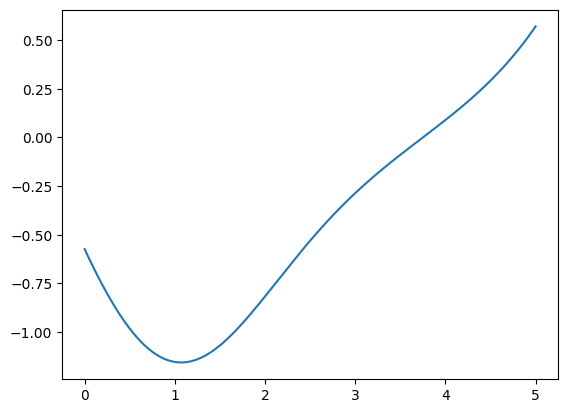

In [39]:
plt.figure()
plt.plot(t, U_d)
plt.show()

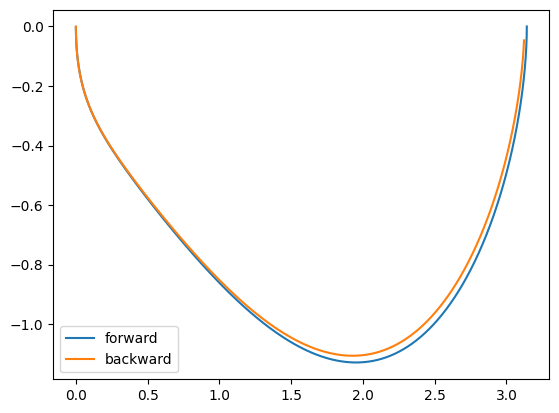

In [40]:
plt.figure()
plt.plot(X_pred_det[:,0,0], X_pred_det[:,0,1], label='forward')
plt.plot(X_backward_u[:,0,0], X_backward_u[:,0,1], label='backward')
plt.legend()
plt.show()

In [41]:
print(X_pred_det[:,0,:])

tensor([[ 3.1416e+00,  0.0000e+00],
        [ 3.1416e+00, -2.2949e-03],
        [ 3.1416e+00, -4.6059e-03],
        ...,
        [ 3.9410e-05, -6.8243e-03],
        [ 1.2113e-05, -4.5651e-03],
        [-6.1479e-06, -2.2955e-03]])


In [42]:
print(X_backward_u[:,0,:])

tensor([[ 3.1222e+00, -4.6584e-02],
        [ 3.1220e+00, -4.8798e-02],
        [ 3.1218e+00, -5.1028e-02],
        ...,
        [ 9.0778e-06, -4.5282e-03],
        [ 0.0000e+00, -2.2694e-03],
        [ 0.0000e+00,  0.0000e+00]])


In [206]:
A = np.array([[0, 1], [1, -0.01]])
B = np.array([[0], [1]])
Q_f = np.eye(2) * (1/0.5**2)
Q = np.eye(2) 
R = np.eye(1)


In [207]:
from scipy.integrate import solve_ivp
# from utils import solve_lqr

In [208]:
def solve_riccati(A, B, Q, R, Q_f, T, dt, dim=2):

    def riccati_eq(t, P_flat, A, B, Q, R, dim=2):
        P = P_flat.reshape((dim,dim))
        R_inv = np.linalg.inv(R)
        dPdt = -(A.T@P + P@A - P@B@R_inv@B.T@P + Q)
        return dPdt.flatten()
    steps = int(T/dt)
    P_T = Q_f
    t_span = [T, 0]
    P_T_flat = P_T.flatten()
    sol = solve_ivp(riccati_eq, t_span, P_T_flat, args=(A, B, Q, R, dim), method='RK45', dense_output=True)
    t = np.linspace(T, 0, steps)
    G = sol.sol(t)
    G_reversed = G[:,::-1]
    G_reversed = G_reversed.reshape((dim,dim,steps))
    return G_reversed

In [209]:
P = solve_riccati(A, B, Q, R, Q_f, 5.0, 0.004)

In [210]:
P.shape

(2, 2, 1250)

In [211]:
W_forward = torch.zeros((1251, 1000, m))
for k in range(1251):
    W_forward[k,:,:] = torch.randn(1000,m)*np.sqrt(0.004)

In [212]:
X_pred_lqr = torch.zeros((1251, 1000, n))
X_pred_lqr[0,:1000//2,:] = x_0.repeat(1,500).T
X_pred_lqr[0,1000//2:,:] = -x_0.repeat(1,500).T
P = torch.tensor(P.copy(), dtype=torch.float32)

In [213]:
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
Q_f = torch.tensor(Q_f, dtype=torch.float32)
Q = torch.tensor(Q, dtype=torch.float32)
R = torch.tensor(R, dtype=torch.float32)

In [214]:
epsilon = 1

In [215]:
u_record = torch.zeros((1251, 1000))

In [216]:
for k in range(1, 1251):

    u = -torch.linalg.inv(R) @ B.T @ P[:,:,k-1] @ X_pred_lqr[k-1,:,:].T
    u_record[k-1,:] = u
    df1_det = X_pred_lqr[k-1,:,1]
    df2_det = torch.sin(X_pred_lqr[k-1,:,0]) - 0.01 * X_pred_lqr[k-1,:,1]
    df_det = torch.stack((df1_det, df2_det), axis=1)
    dX_det = (df_det.T  + B @ u).T * 0.004 + (B @ (epsilon * W_forward[k-1,:,:]).T).T
    X_pred_lqr[k,:,:] = X_pred_lqr[k-1,:,:] + dX_det

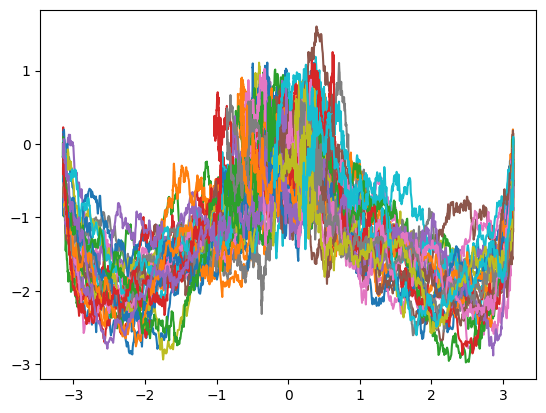

In [217]:
plt.figure()
for i in range(50):
    # plt.plot(X_pred_lqr[:,i,0], X_pred_lqr[:,i,1])
    plt.plot(X_pred_lqr[:,i-25,0], X_pred_lqr[:,i,1])
# plt.plot(X_pred_det[:,0,0], X_pred_det[:,0,1], label='forward')

In [218]:
(X_pred_lqr[-1,:,:]**2).sum(axis=1).mean()


tensor(0.3281)

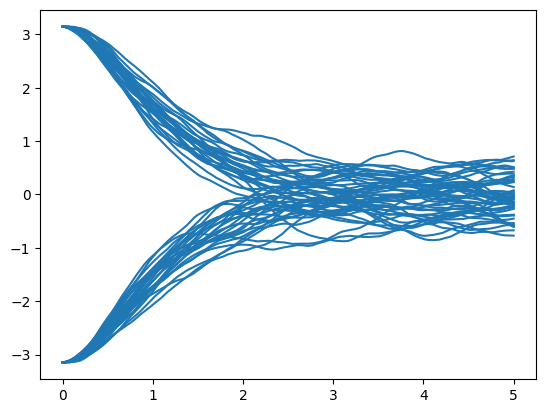

In [219]:
plt.figure()
for i in range(50):
    plt.plot(np.arange(1251)*0.004, X_pred_lqr[:,i-25,0],color='C0')
plt.show()

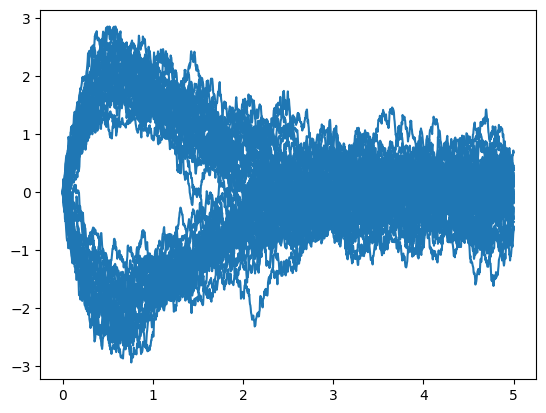

In [220]:
plt.figure()
for i in range(50):
    plt.plot(np.arange(1251)*0.004, X_pred_lqr[:,i-25,1],color='C0')
plt.show()

In [221]:
print((X_pred_lqr[-1,:,:]**2).sum(axis=1).mean())

tensor(0.3281)


In [180]:
IP_u_traj = torch.load('IP_u1_sigma0.0_epsilon1_N1000_T1251.pt')

/var/folders/pd/hp6m3j2j5v9bd6w64h7wl3rm0000gn/T/ipykernel_38613/1059046598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  IP_u_traj = torch.load('IP_u1_sigma0.0_epsilo

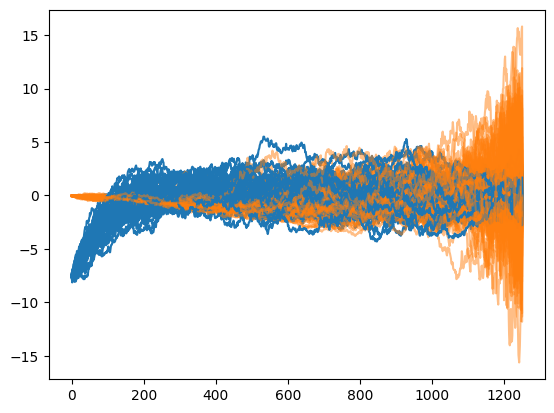

In [223]:
plt.figure()
for i in range(50):
    plt.plot(u_record[:,i],color='C0')
    plt.plot(IP_u_traj[:,i,0].detach().numpy(), color='C1', alpha=0.5)
# plt.plot(np.arange(1251)*0.004, u_record[:,0])
plt.show()

In [222]:
(u_record**2).sum(axis=1).mean()

tensor(3808.2000)

In [186]:
(IP_u_traj**2).sum(axis=1).mean()

tensor(3778.4805, grad_fn=<MeanBackward0>)

In [238]:
lin_A = np.array([[0, 0], [0, 0]])
lin_B = np.eye(2)
lin_Q_f = np.eye(2) * (1/0.05**2)
lin_Q = np.eye(2) 
lin_R = np.eye(2)

In [239]:
lin_P = solve_riccati(lin_A, lin_B, lin_Q, lin_R, lin_Q_f, 1.0, 0.004)

In [240]:
X_pred_lqr_lin = torch.zeros((251, 1000, n))
X_pred_lqr_lin[0,:,:] += torch.tensor([2.0,2.0])

In [241]:
lin_P = torch.tensor(lin_P.copy(), dtype=torch.float32)
lin_A = torch.tensor(lin_A, dtype=torch.float32)
lin_B = torch.tensor(lin_B, dtype=torch.float32)
lin_Q_f = torch.tensor(lin_Q_f, dtype=torch.float32)
lin_Q = torch.tensor(lin_Q, dtype=torch.float32)
lin_R = torch.tensor(lin_R, dtype=torch.float32)

In [242]:
for k in range(1, 251):

    u = -torch.linalg.inv(lin_R) @ lin_B.T @ lin_P[:,:,k-1] @ X_pred_lqr_lin[k-1,:,:].T
    # u_record[k-1,:] = u
    dX_det = (lin_A @ X_pred_lqr_lin[k-1,:,:].T  + lin_B @ u).T * 0.004 + (lin_B @ (0.3 * torch.randn(1000,2)*np.sqrt(0.004)).T).T
    X_pred_lqr_lin[k,:,:] = X_pred_lqr_lin[k-1,:,:] + dX_det

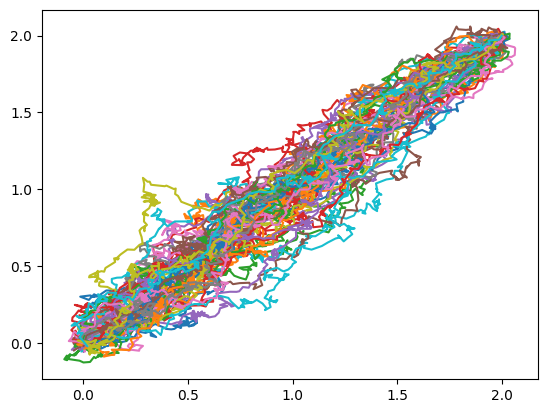

In [243]:
plt.figure()
for i in range(50):
    plt.plot(X_pred_lqr_lin[:,i,0], X_pred_lqr_lin[:,i,1])
plt.show()

In [244]:
(X_pred_lqr_lin[-1,:,:]**2).sum(axis=1).mean()

tensor(0.0011)